# Задача 7. Нейронные сети

- Найти данные в виде изображений для задачи классификации.
- Реализовать классы, необходимые для построения сети со следующими слоями
  - FullyConnectedLayer
  - ReluLayer
  - FullyConnectedLayer
- Использовать CrossEntropyLoss и L2-регуляризацию.
- Обучить модель на тренировочных данных, подбирать параметры (особенно learning rate) на валидационной и оценить качество на тестовой. Анализировать графики train/val loss, проверять на каждом шаге корректность вычисления градиентов с помощью разностной оценки.
- (+2 балла) Добавить Batch normalization.
- (+2 балла) В качестве оптимизатор использовать один из: Momentum, RMSprop.
- (+1 балл) Также реализовать оптимизатор Adam.

## Импортируем зависимости

In [1]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
import pandas as pd

from torch import optim
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from itertools import product
from collections import defaultdict

## Датасет

В этом решении был выбран датасет [MNIST Dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset)

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

In [3]:
train_dataset = MNIST(
    root="./dataset",
    train=True,
    download=True,
    transform=transform)

test_dataset = MNIST(
    root="./dataset",
    train=False,
    download=True,
    transform=transform)

In [4]:
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Визуализируем его

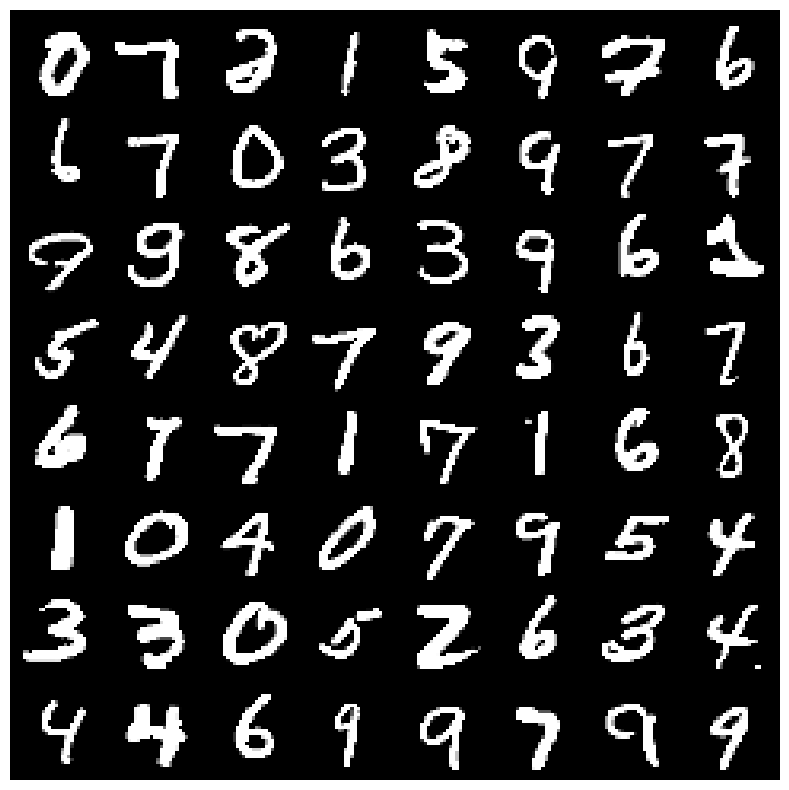

In [5]:
def show_batch(image_tensor, denormalize=None):
    if image_tensor.dim() == 4:
        grid = torchvision.utils.make_grid(image_tensor, nrow=8, padding=2)
    else:
        grid = image_tensor

    if denormalize:
        grid = denormalize(grid)

    grid_np = grid.numpy()
    grid_np = np.transpose(grid_np, (1, 2, 0))

    if grid_np.min() < 0 or grid_np.max() > 1:
        grid_np = np.clip(grid_np, 0, 1)

    plt.figure(figsize=(12, 8))
    plt.imshow(grid_np)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

images, labels = next(iter(trainloader))
denorm = None

show_batch(images, denormalize=denorm)

## Построение нейронной сети

In [6]:
class FullyConnectedLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_features, out_features) * 0.1)
        self.bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        self.x = x
        return x @ self.weight + self.bias

In [7]:
class ReluLayer(nn.Module):
    def forward(self, x):
        self.x = x
        return F.relu(x)

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_size=128, batch_normalization=False):
        super().__init__()
        self.batch_normalization = batch_normalization

        self.fc1 = FullyConnectedLayer(1*28*28, hidden_size)
        self.relu1 = ReluLayer()
        self.bn1 = nn.BatchNorm1d(hidden_size) if batch_normalization else None
        self.fc2 = FullyConnectedLayer(hidden_size, 10)

    def forward(self, x):
        x = x.view(-1, 1*28*28)
        x = self.fc1(x)
        x = self.relu1(x)
        if self.batch_normalization:
            x = self.bn1(x)
        x = self.fc2(x)
        return x

## Оптимизатор Adam

С добавлением L2 регуляризации

In [9]:
class AdamOptimizer:
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0):
        self.params = list(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.weight_decay = weight_decay
        self.t = 0

        self.m = [torch.zeros_like(p.data) for p in self.params]
        self.v = [torch.zeros_like(p.data) for p in self.params]

    def step(self):
        self.t += 1

        bias_correction1 = 1 - self.beta1 ** self.t
        bias_correction2 = 1 - self.beta2 ** self.t

        for i, param in enumerate(self.params):
            if param.grad is None:
                continue

            grad = param.grad.data

            # L2 regularization
            if self.weight_decay != 0:
                grad.add_(param.data, alpha=self.weight_decay)

            self.m[i].mul_(self.beta1).add_(grad, alpha=1 - self.beta1)
            self.v[i].mul_(self.beta2).add_(grad.pow(2), alpha=1 - self.beta2)

            m_hat = self.m[i] / bias_correction1
            v_hat = self.v[i] / bias_correction2

            denom = v_hat.sqrt_().add_(self.eps)
            param.data.addcdiv_(m_hat, denom, value=-self.lr)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

def get_optimizer(name, params, lr, **kwargs):
    if name == 'adam':
        return AdamOptimizer(params, lr=lr, **kwargs)
    elif name == 'momentum':
        return optim.SGD(params, lr=lr, momentum=0.9, **kwargs)
    elif name == 'sgd':
        return optim.SGD(params, lr=lr, **kwargs)
    else:
        available = ['adam', 'momentum', 'sgd']
        raise ValueError(
            f"Unsupported optimizer: '{name}'. "
            f"Available options are: {available}"
        )

## Процесс обучения

In [10]:
def train_model(model, train_loader, test_loader, loss_fn, optimizer, num_epochs=10):
    result = {
        'train_loss': [],
        'val_loss': [],
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_samples = 0

        for i, (inputs, targets) in enumerate(train_loader):
            # forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

        epoch_train_loss = running_loss / total_samples
        result['train_loss'].append(epoch_train_loss)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == targets).sum().item()
                total += targets.size(0)

        epoch_val_loss = val_loss / total
        result['val_loss'].append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} | ")

    return model, result

#### Обучим на 10 эпохах и посмотрим качество сети

В качестве оптимизатора выберем реализованный здесь Adam, а в качестве функции лосса - CrossEntropyLoss

In [13]:
model = NeuralNetwork()
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = AdamOptimizer(
    model.parameters(),
    lr=0.001,
    betas=(0.9, 0.999),
    weight_decay=1e-5  # L2 regularization
)

import time
start_time = time.time()

trained_model, history = train_model(
    model,
    trainloader,
    testloader,
    loss_fn,
    optimizer,
    num_epochs=10
)

training_time = time.time() - start_time
print(f"{training_time:.2f} seconds")

NeuralNetwork(
  (fc1): FullyConnectedLayer()
  (relu1): ReluLayer()
  (fc2): FullyConnectedLayer()
)
Epoch 1/10 | Train Loss: 0.2893 | Val Loss: 0.1661 | 
Epoch 2/10 | Train Loss: 0.1190 | Val Loss: 0.1095 | 
Epoch 3/10 | Train Loss: 0.0833 | Val Loss: 0.0971 | 
Epoch 4/10 | Train Loss: 0.0626 | Val Loss: 0.0940 | 
Epoch 5/10 | Train Loss: 0.0484 | Val Loss: 0.0910 | 
Epoch 6/10 | Train Loss: 0.0396 | Val Loss: 0.0838 | 
Epoch 7/10 | Train Loss: 0.0324 | Val Loss: 0.0885 | 
Epoch 8/10 | Train Loss: 0.0261 | Val Loss: 0.0951 | 
Epoch 9/10 | Train Loss: 0.0231 | Val Loss: 0.0904 | 
Epoch 10/10 | Train Loss: 0.0206 | Val Loss: 0.1065 | 
209.76 seconds



performance Summary:
 - Final Train Loss: 0.0206
 - Final Val Loss: 0.1065
 - Best Val Loss: 0.0838 (epoch 6)
 - Training Time: 209.76s


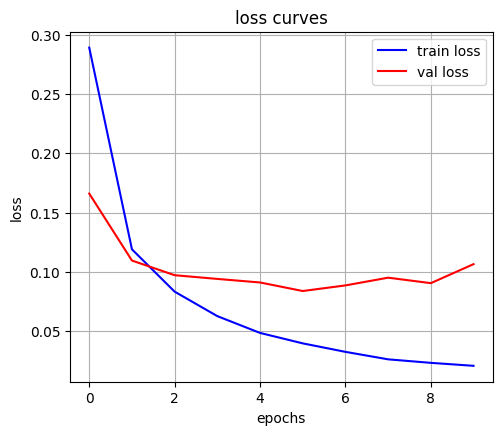

In [16]:
plt.figure(figsize=(12, 10))

# Loss plot
plt.subplot(2, 2, 1)
plt.plot(history['train_loss'], 'b-', label='train loss')
plt.plot(history['val_loss'], 'r-', label='val loss')
plt.title('loss curves')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid(True)

print("\nperformance Summary:")
for text in summary_text:
    print(f" - {text}")

Довольно хороший результат для 10 эпох

## Подбор гиперпараметров

Сделаем перебор параметров модели и посмотрим результаты

In [34]:
config = {
    'models': [{'batch_norm': False},
               {'batch_norm': True,}],
    'lr': [0.001, 0.01, 0.1],
    'optimizers': ['adam', 'sgd'],
}

In [35]:
def run_experiments(models, lrs, optimizers, num_epochs=10):
    torch.manual_seed(42)
    results = []

    for model_config, lr, optim_name in product(models, lrs, optimizers):
        model = NeuralNetwork(batch_normalization=model_config['batch_norm'])
        criterion = nn.CrossEntropyLoss()
        optimizer = get_optimizer(optim_name, model.parameters(), lr)

        print(f"\nTraining {model.__class__.__name__} "
              f"with lr={lr}, optimizer={optim_name}, "
              f"batch norm={model_config['batch_norm']}")

        _, history = train_model(
            model,
            trainloader,
            testloader,
            criterion,
            optimizer,
            num_epochs=10
        )

        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.legend()
        plt.show()
        print(results)

    return results


Training NeuralNetwork with lr=0.001, optimizer=adam, batch norm=False
Epoch 1/10 | Train Loss: 0.2794 | Val Loss: 0.1468 | 
Epoch 2/10 | Train Loss: 0.1152 | Val Loss: 0.1015 | 
Epoch 3/10 | Train Loss: 0.0788 | Val Loss: 0.0956 | 
Epoch 4/10 | Train Loss: 0.0590 | Val Loss: 0.0940 | 
Epoch 5/10 | Train Loss: 0.0484 | Val Loss: 0.0891 | 
Epoch 6/10 | Train Loss: 0.0374 | Val Loss: 0.0859 | 
Epoch 7/10 | Train Loss: 0.0307 | Val Loss: 0.0786 | 
Epoch 8/10 | Train Loss: 0.0247 | Val Loss: 0.0815 | 
Epoch 9/10 | Train Loss: 0.0219 | Val Loss: 0.0964 | 
Epoch 10/10 | Train Loss: 0.0194 | Val Loss: 0.0869 | 


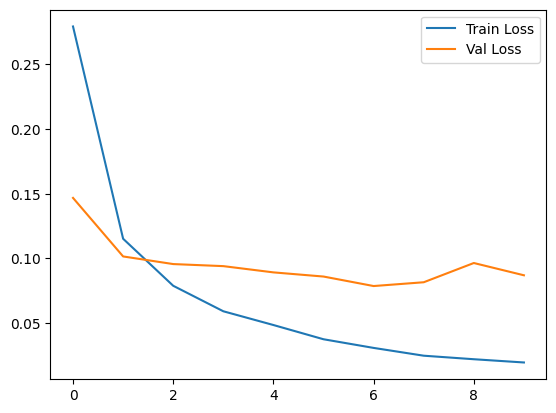

[]

Training NeuralNetwork with lr=0.001, optimizer=sgd, batch norm=False
Epoch 1/10 | Train Loss: 1.4470 | Val Loss: 0.7852 | 
Epoch 2/10 | Train Loss: 0.6807 | Val Loss: 0.5656 | 
Epoch 3/10 | Train Loss: 0.5403 | Val Loss: 0.4811 | 
Epoch 4/10 | Train Loss: 0.4744 | Val Loss: 0.4349 | 
Epoch 5/10 | Train Loss: 0.4340 | Val Loss: 0.4038 | 
Epoch 6/10 | Train Loss: 0.4058 | Val Loss: 0.3827 | 
Epoch 7/10 | Train Loss: 0.3847 | Val Loss: 0.3646 | 
Epoch 8/10 | Train Loss: 0.3677 | Val Loss: 0.3510 | 
Epoch 9/10 | Train Loss: 0.3536 | Val Loss: 0.3388 | 
Epoch 10/10 | Train Loss: 0.3417 | Val Loss: 0.3289 | 


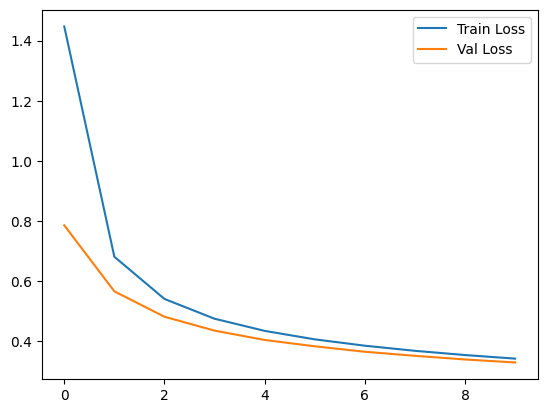

[]

Training NeuralNetwork with lr=0.01, optimizer=adam, batch norm=False
Epoch 1/10 | Train Loss: 0.2857 | Val Loss: 0.2128 | 
Epoch 2/10 | Train Loss: 0.2027 | Val Loss: 0.2437 | 
Epoch 3/10 | Train Loss: 0.1872 | Val Loss: 0.2444 | 
Epoch 4/10 | Train Loss: 0.1920 | Val Loss: 0.2494 | 
Epoch 5/10 | Train Loss: 0.1763 | Val Loss: 0.2556 | 
Epoch 6/10 | Train Loss: 0.1688 | Val Loss: 0.2192 | 
Epoch 7/10 | Train Loss: 0.1683 | Val Loss: 0.2668 | 
Epoch 8/10 | Train Loss: 0.1666 | Val Loss: 0.2664 | 
Epoch 9/10 | Train Loss: 0.1539 | Val Loss: 0.3096 | 
Epoch 10/10 | Train Loss: 0.1574 | Val Loss: 0.2422 | 


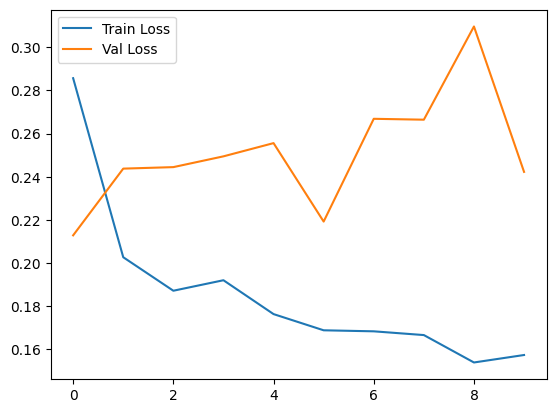

[]

Training NeuralNetwork with lr=0.01, optimizer=sgd, batch norm=False
Epoch 1/10 | Train Loss: 0.5373 | Val Loss: 0.3347 | 
Epoch 2/10 | Train Loss: 0.3001 | Val Loss: 0.2671 | 
Epoch 3/10 | Train Loss: 0.2503 | Val Loss: 0.2389 | 
Epoch 4/10 | Train Loss: 0.2199 | Val Loss: 0.2132 | 
Epoch 5/10 | Train Loss: 0.1974 | Val Loss: 0.1952 | 
Epoch 6/10 | Train Loss: 0.1801 | Val Loss: 0.1834 | 
Epoch 7/10 | Train Loss: 0.1659 | Val Loss: 0.1706 | 
Epoch 8/10 | Train Loss: 0.1542 | Val Loss: 0.1598 | 
Epoch 9/10 | Train Loss: 0.1437 | Val Loss: 0.1534 | 
Epoch 10/10 | Train Loss: 0.1351 | Val Loss: 0.1465 | 


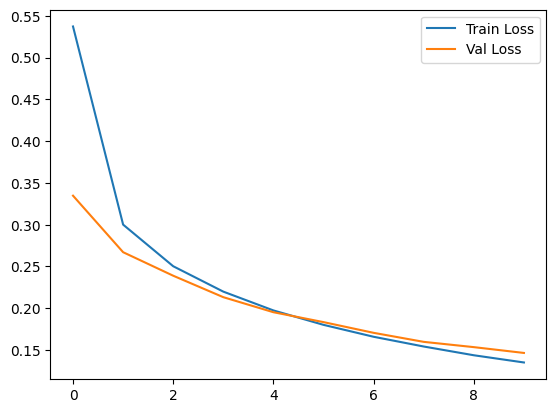

[]

Training NeuralNetwork with lr=0.1, optimizer=adam, batch norm=False
Epoch 1/10 | Train Loss: 2.2700 | Val Loss: 2.0415 | 
Epoch 2/10 | Train Loss: 2.2730 | Val Loss: 2.2656 | 
Epoch 3/10 | Train Loss: 2.2141 | Val Loss: 2.2342 | 
Epoch 4/10 | Train Loss: 2.2755 | Val Loss: 2.2994 | 
Epoch 5/10 | Train Loss: 2.2234 | Val Loss: 2.2477 | 
Epoch 6/10 | Train Loss: 2.2399 | Val Loss: 2.3148 | 
Epoch 7/10 | Train Loss: 2.1991 | Val Loss: 2.3491 | 
Epoch 8/10 | Train Loss: 2.1980 | Val Loss: 2.3324 | 
Epoch 9/10 | Train Loss: 2.2437 | Val Loss: 2.3294 | 
Epoch 10/10 | Train Loss: 2.1946 | Val Loss: 2.3124 | 


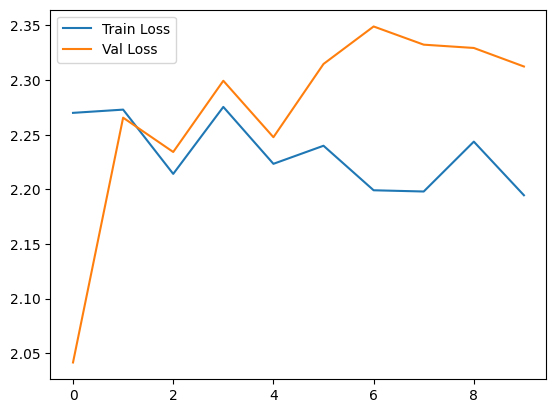

[]

Training NeuralNetwork with lr=0.1, optimizer=sgd, batch norm=False
Epoch 1/10 | Train Loss: 0.2783 | Val Loss: 0.1480 | 
Epoch 2/10 | Train Loss: 0.1277 | Val Loss: 0.1100 | 
Epoch 3/10 | Train Loss: 0.0903 | Val Loss: 0.1005 | 
Epoch 4/10 | Train Loss: 0.0682 | Val Loss: 0.0913 | 
Epoch 5/10 | Train Loss: 0.0536 | Val Loss: 0.1022 | 
Epoch 6/10 | Train Loss: 0.0436 | Val Loss: 0.0878 | 
Epoch 7/10 | Train Loss: 0.0349 | Val Loss: 0.0844 | 
Epoch 8/10 | Train Loss: 0.0281 | Val Loss: 0.0885 | 
Epoch 9/10 | Train Loss: 0.0225 | Val Loss: 0.0843 | 
Epoch 10/10 | Train Loss: 0.0186 | Val Loss: 0.0957 | 


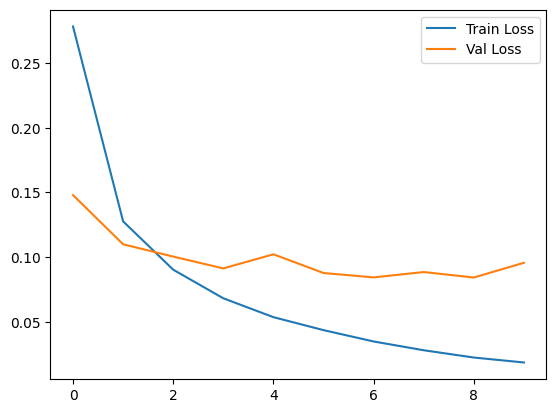

[]

Training NeuralNetwork with lr=0.001, optimizer=adam, batch norm=True
Epoch 1/10 | Train Loss: 0.2916 | Val Loss: 0.1471 | 
Epoch 2/10 | Train Loss: 0.1250 | Val Loss: 0.0988 | 
Epoch 3/10 | Train Loss: 0.0871 | Val Loss: 0.0865 | 
Epoch 4/10 | Train Loss: 0.0672 | Val Loss: 0.0768 | 
Epoch 5/10 | Train Loss: 0.0558 | Val Loss: 0.0805 | 
Epoch 6/10 | Train Loss: 0.0449 | Val Loss: 0.0774 | 
Epoch 7/10 | Train Loss: 0.0412 | Val Loss: 0.0773 | 
Epoch 8/10 | Train Loss: 0.0328 | Val Loss: 0.0738 | 
Epoch 9/10 | Train Loss: 0.0300 | Val Loss: 0.0758 | 
Epoch 10/10 | Train Loss: 0.0260 | Val Loss: 0.0757 | 


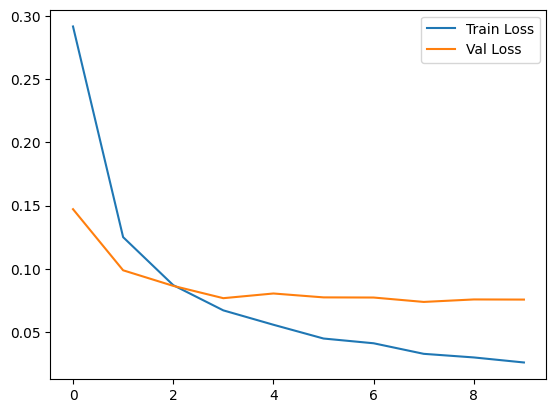

[]

Training NeuralNetwork with lr=0.001, optimizer=sgd, batch norm=True
Epoch 1/10 | Train Loss: 1.6436 | Val Loss: 1.0168 | 
Epoch 2/10 | Train Loss: 0.8858 | Val Loss: 0.7129 | 
Epoch 3/10 | Train Loss: 0.6908 | Val Loss: 0.5915 | 
Epoch 4/10 | Train Loss: 0.5946 | Val Loss: 0.5222 | 
Epoch 5/10 | Train Loss: 0.5372 | Val Loss: 0.4750 | 
Epoch 6/10 | Train Loss: 0.4963 | Val Loss: 0.4423 | 
Epoch 7/10 | Train Loss: 0.4667 | Val Loss: 0.4169 | 
Epoch 8/10 | Train Loss: 0.4420 | Val Loss: 0.3937 | 
Epoch 9/10 | Train Loss: 0.4229 | Val Loss: 0.3788 | 
Epoch 10/10 | Train Loss: 0.4076 | Val Loss: 0.3625 | 


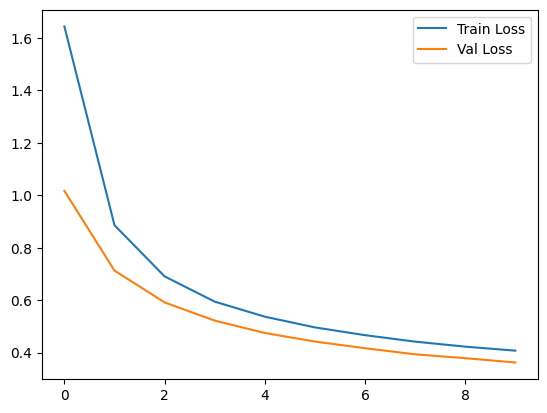

[]

Training NeuralNetwork with lr=0.01, optimizer=adam, batch norm=True
Epoch 1/10 | Train Loss: 0.2361 | Val Loss: 0.2001 | 
Epoch 2/10 | Train Loss: 0.1310 | Val Loss: 0.1233 | 
Epoch 3/10 | Train Loss: 0.1031 | Val Loss: 0.1616 | 
Epoch 4/10 | Train Loss: 0.0883 | Val Loss: 0.1416 | 
Epoch 5/10 | Train Loss: 0.0802 | Val Loss: 0.1232 | 
Epoch 6/10 | Train Loss: 0.0703 | Val Loss: 0.1010 | 
Epoch 7/10 | Train Loss: 0.0665 | Val Loss: 0.1026 | 
Epoch 8/10 | Train Loss: 0.0596 | Val Loss: 0.0954 | 
Epoch 9/10 | Train Loss: 0.0551 | Val Loss: 0.0999 | 
Epoch 10/10 | Train Loss: 0.0523 | Val Loss: 0.0942 | 


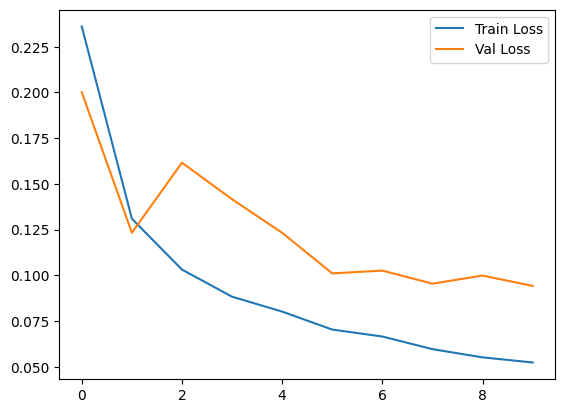

[]

Training NeuralNetwork with lr=0.01, optimizer=sgd, batch norm=True
Epoch 1/10 | Train Loss: 0.6665 | Val Loss: 0.3713 | 
Epoch 2/10 | Train Loss: 0.3606 | Val Loss: 0.2927 | 
Epoch 3/10 | Train Loss: 0.3003 | Val Loss: 0.2544 | 
Epoch 4/10 | Train Loss: 0.2645 | Val Loss: 0.2288 | 
Epoch 5/10 | Train Loss: 0.2368 | Val Loss: 0.2073 | 
Epoch 6/10 | Train Loss: 0.2162 | Val Loss: 0.1935 | 
Epoch 7/10 | Train Loss: 0.1996 | Val Loss: 0.1825 | 
Epoch 8/10 | Train Loss: 0.1875 | Val Loss: 0.1701 | 
Epoch 9/10 | Train Loss: 0.1762 | Val Loss: 0.1633 | 
Epoch 10/10 | Train Loss: 0.1639 | Val Loss: 0.1569 | 


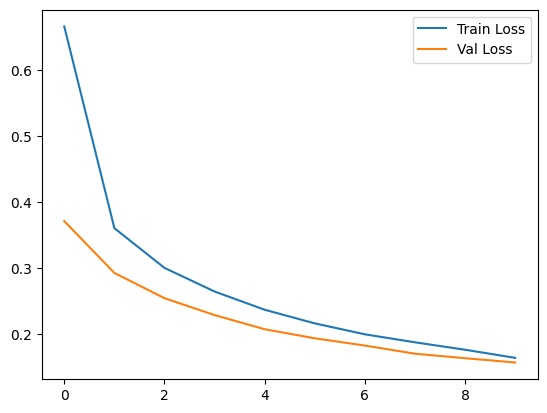

[]

Training NeuralNetwork with lr=0.1, optimizer=adam, batch norm=True
Epoch 1/10 | Train Loss: 0.4241 | Val Loss: 1.8760 | 
Epoch 2/10 | Train Loss: 0.3493 | Val Loss: 0.7042 | 
Epoch 3/10 | Train Loss: 0.3040 | Val Loss: 1.0956 | 
Epoch 4/10 | Train Loss: 0.2865 | Val Loss: 1.4902 | 
Epoch 5/10 | Train Loss: 0.3012 | Val Loss: 0.8800 | 
Epoch 6/10 | Train Loss: 0.3204 | Val Loss: 1.6950 | 
Epoch 7/10 | Train Loss: 0.3151 | Val Loss: 0.8437 | 
Epoch 8/10 | Train Loss: 0.2937 | Val Loss: 4.2210 | 
Epoch 9/10 | Train Loss: 0.2803 | Val Loss: 3.0047 | 
Epoch 10/10 | Train Loss: 0.2844 | Val Loss: 1.9969 | 


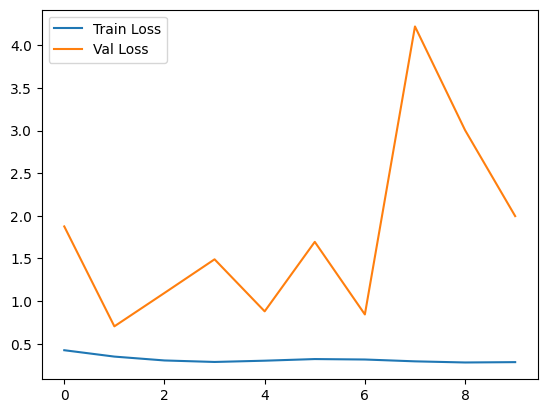

[]

Training NeuralNetwork with lr=0.1, optimizer=sgd, batch norm=True
Epoch 1/10 | Train Loss: 0.3017 | Val Loss: 0.1574 | 
Epoch 2/10 | Train Loss: 0.1485 | Val Loss: 0.1169 | 
Epoch 3/10 | Train Loss: 0.1092 | Val Loss: 0.1027 | 
Epoch 4/10 | Train Loss: 0.0864 | Val Loss: 0.0938 | 
Epoch 5/10 | Train Loss: 0.0719 | Val Loss: 0.0868 | 
Epoch 6/10 | Train Loss: 0.0616 | Val Loss: 0.0857 | 
Epoch 7/10 | Train Loss: 0.0516 | Val Loss: 0.0839 | 
Epoch 8/10 | Train Loss: 0.0455 | Val Loss: 0.0806 | 
Epoch 9/10 | Train Loss: 0.0389 | Val Loss: 0.0818 | 
Epoch 10/10 | Train Loss: 0.0354 | Val Loss: 0.0798 | 


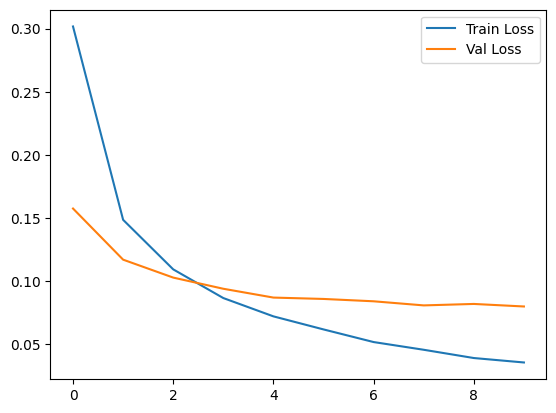

[]


[]

In [36]:
run_experiments(
    models=config['models'],
    lrs=config['lr'],
    optimizers=config['optimizers'],
)